In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
train = pd.DataFrame.from_csv("./train_full.csv")

In [169]:
# Natural accuracy:
1.-train.burned.mean()

0.84088557860039725

# baseline

In [4]:
train.columns

Index([u'cancel_time', u'dist', u'driver_found', u'due', u'f_class', u'lat',
       u'lon', u's_class', u't_class', u'burned', u'time_of_day',
       u'day_of_week', u'day_abs'],
      dtype='object')

In [5]:
from sklearn.feature_extraction import DictVectorizer
dictvec = DictVectorizer(sparse=False,dtype=np.bool)


categorical = [ {'f_class':f,'s_class':s,'t_class':t,'day_of_week':str(wday)}
               for f,s,t,wday in train[['f_class','s_class','t_class','day_of_week']].values[::1000] ]

dictvec.fit(categorical)


DictVectorizer(dtype=<type 'bool'>, separator='=', sort=True, sparse=False)

In [6]:
dictvec.feature_names_

['day_of_week=1',
 'day_of_week=2',
 'day_of_week=3',
 'day_of_week=4',
 'day_of_week=5',
 'day_of_week=6',
 'day_of_week=7',
 'f_class',
 'f_class=business',
 'f_class=econom',
 'f_class=vip',
 's_class',
 's_class=business',
 's_class=econom',
 's_class=vip',
 't_class',
 't_class=econom',
 't_class=vip']

In [7]:
train.burned.describe()

count     2180676
mean     0.159114
std      0.365783
min         False
25%             0
50%             0
75%             0
max          True
Name: burned, dtype: object

In [204]:
def preproc(data):
    categorical = [ {'f_class':f,'s_class':s,'t_class':t,'day_of_week':str(wday)}
               for f,s,t,wday in data[['f_class','s_class','t_class','day_of_week']].values ]

    Xcat = dictvec.transform(categorical)
    
    real_features = ["dist","lat","lon","time_of_day"]
    X = np.concatenate([
            data[real_features].values,
            Xcat            
        ],axis=1)
    
    return pd.DataFrame(X,columns=real_features+dictvec.feature_names_),train["burned"].values

In [205]:
X,y = preproc(train)

In [206]:
from sklearn.cross_validation import train_test_split
Xtr,Xval,Ytr,Yval = train_test_split(X,y,test_size=0.2,random_state=222)

In [207]:
#reweighting (mnot used)
wpos, wneg = 0.5/Ytr.mean(), 0.5/(1-Ytr.mean())

Wtr = np.ones_like(Ytr,dtype='float32')
Wtr[Ytr]=wpos
Wtr[~Ytr]=wneg

In [208]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=128,n_jobs=-1,min_samples_leaf=10)
rf.fit(Xtr,Ytr)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=128, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [209]:
Yval_pred_proba = rf.predict_proba(Xval)
Ytrain_pred_proba = rf.predict_proba(Xtr)

In [210]:
thr = 0.5
Yval_pred = Yval_pred_proba[:,1]>thr
Ytrain_pred = Ytrain_pred_proba[:,1]>thr

In [211]:
from sklearn.metrics import roc_auc_score,accuracy_score

print 'auc train = %.5f \t auc test=%.5f'%(roc_auc_score(Ytr,Ytrain_pred_proba[:,1]),roc_auc_score(Yval,Yval_pred_proba[:,1]))
print 'acc train = %.5f \t acc test=%.5f'%(accuracy_score(Ytr,Ytrain_pred),accuracy_score(Yval,Yval_pred))

auc train = 0.91249 	 auc test=0.66893
acc train = 0.84803 	 acc test=0.84354


Feature ranking:
1. feature 0 (0.288669)
2. feature 2 (0.250222)
3. feature 1 (0.246508)
4. feature 3 (0.180719)
5. feature 9 (0.003226)
6. feature 8 (0.003147)
7. feature 7 (0.002943)
8. feature 6 (0.002730)
9. feature 10 (0.002688)
10. feature 5 (0.002662)
11. feature 14 (0.002630)
12. feature 4 (0.002537)
13. feature 15 (0.002089)
14. feature 16 (0.001843)
15. feature 12 (0.001830)
16. feature 13 (0.001732)
17. feature 19 (0.000966)
18. feature 11 (0.000920)
19. feature 18 (0.000835)
20. feature 21 (0.000721)
21. feature 17 (0.000307)
22. feature 20 (0.000077)


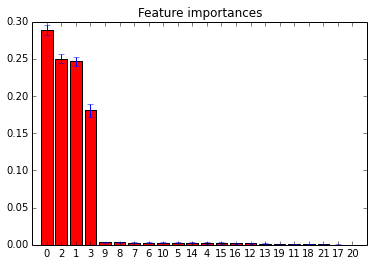

In [212]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Cities

In [20]:
with open("cities.txt") as fin:
    s = fin.read()
    
lines = s.split('\n')[1:-1]

In [21]:
deg = "\xc2\xb0"


rows = []
for line in  lines:
    sname,sloc = line.split('\t')
    
    while sname.startswith(' '): sname = sname[1:]
    while sname.endswith(' '): sname= sname[:-1]
    
    slat,slon = sloc[:-6].split('с.ш.')
    
    lat_deg = int(slat[:slat.index(deg)])
    lat_min = int(slat[slat.index(deg)+2:-2])
    lat = lat_deg+lat_min/60.
    
    lon_deg = int(slon[:slon.index(deg)])
    lon_min = int(slon[slon.index(deg)+2:-2])
    lon = lon_deg+lon_min/60.

    rows.append([sname,lat,lon])
    
    
cities = pd.DataFrame(rows,columns=["name","lat","lon"])

In [23]:
min_dist = np.zeros_like(cities.name)
for i,(city,lat,lon) in cities.iterrows():
    
    dist = np.sqrt((train.lat - lat)**2 +  (train.lon-lon)**2)
    
    dist = np.sort(dist)
    
    min_dist[i]= dist[10]

In [30]:
active_cities = cities[min_dist <0.1]

In [73]:
major_city_names = ["Москва","Санкт-Петербург","Воронеж","Нижний Новгород","Казань"]

major_cities = cities[np.in1d(cities.name.values,major_city_names)]


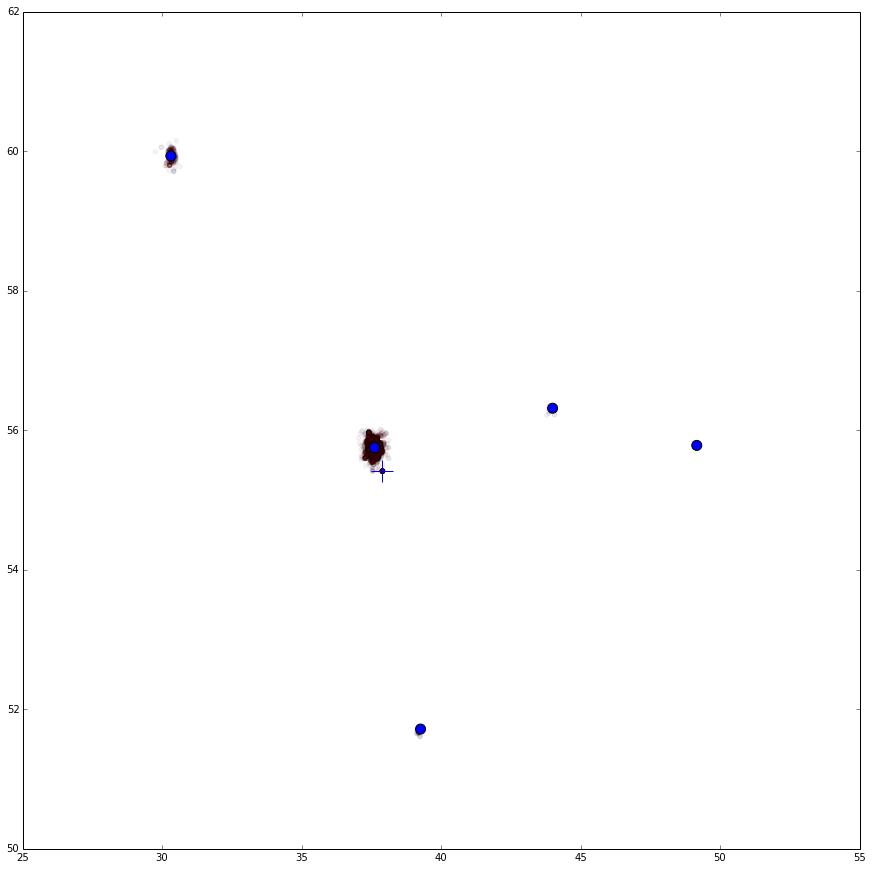

In [74]:
plt.figure(figsize=[15,15])
df = train[:10000]
plt.scatter(df.lon,df.lat, c = df.driver_found,alpha = 0.05)

#plt.scatter(active_cities.lat,active_cities.lon)
plt.scatter(major_cities.lon,major_cities.lat,s=100)


#домодедово
plt.scatter([37.886248],[55.414108],marker='+',s=500)

#plt.xlim(36,39)
#plt.ylim(55,57)

In [201]:
major_cities

,name,lat,lon
0,Москва,55.750000,37.616667
1,Санкт-Петербург,59.933333,30.316667
6,Казань,55.783333,49.166667
12,Воронеж,51.716667,39.266667
223,Нижний Новгород,56.316667,44.000000


In [213]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def preproc_new(data):
    X,y = preproc(data)


    for i,(cty_name,cty_lat,cty_lon) in major_cities.iterrows():

        rho,phi = cart2pol(X.lat.values-cty_lat,X.lon.values-cty_lon)

        X["dist_to_"+cty_name] = rho
        X["angle_to"+cty_name] = phi

    closest_city_ids = np.argmin([X["dist_to_"+cty_name] for cty_name in major_city_names],axis=0)

    for i,(cty_name,cty_lat,cty_lon) in major_cities.iterrows():
        X["closest_to_"+cty_name] = closest_city_ids == i

    del X["lat"], X["lon"]
    
    return X,y

In [214]:
X = preproc_new(train)
y = train["burned"].values

In [230]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=128,n_jobs=-1,min_samples_leaf=3)
rf.fit(Xtr,Ytr)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=128, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [231]:
Yval_pred_proba = rf.predict_proba(Xval)
Ytrain_pred_proba = rf.predict_proba(Xtr)
thr = 0.5
Yval_pred = Yval_pred_proba[:,1]>thr
Ytrain_pred = Ytrain_pred_proba[:,1]>thr

In [229]:
from sklearn.metrics import roc_auc_score,accuracy_score

print 'auc train = %.5f \t auc test=%.5f'%(roc_auc_score(Ytr,Ytrain_pred_proba[:,1]),roc_auc_score(Yval,Yval_pred_proba[:,1]))
print 'acc train = %.5f \t acc test=%.5f'%(accuracy_score(Ytr,Ytrain_pred),accuracy_score(Yval,Yval_pred))

auc train = 0.98780 	 auc test=0.66364
acc train = 0.88437 	 acc test=0.84868


# Are we at least better than natural baseline?

In [256]:
score_natural = Yval == 0 
score_rf = Yval_pred == Yval

In [259]:
from scipy.stats import ttest_rel

In [261]:
ttest_rel(score_rf,score_natural)

Ttest_relResult(statistic=169.09182893738267, pvalue=0.0)

In [262]:
#because big data